In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, losses, metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
def training_curve(hist, is_acc):
    history = hist.history
    fig, loss_ax = plt.subplots(figsize=(20, 10))
    loss_ax.plot(history['loss'], label='train loss')
    loss_ax.plot(history['val_loss'], label='val loss')
    if is_acc:
        loss_ax.plot(history['acc'], label='train acc')
        loss_ax.plot(history['val_acc'], label='val acc')
        loss_ax.plot(history['binary_accuracy'], label='train binacc')
        loss_ax.plot(history['val_binary_accuracy'], label='val binacc')
    loss_ax.set_xlabel('epoch')
    loss_ax.legend(loc='upper left')
    plt.show()

In [13]:
def acc(y_true, y_pred):
    compare = K.cast(y_true == K.round(y_pred), dtype='int8')
    allright = K.cast(K.sum(compare, axis=1) == y_true.shape[1], dtype='float32')
    return K.mean(allright)

In [4]:
ir = pd.read_csv('data/ir.csv', index_col='Unnamed: 0').T
ir.reset_index(inplace = True)
interpolate_args = { "method" : "linear", "order" : 1 }
ir.iloc[:, 1:] = ir.iloc[:, 1:].interpolate(**interpolate_args, limit_direction='both', axis = 0)
ir.set_index('index', inplace = True)
ir = ir.div(ir.max(axis=0), axis=1)

ms = pd.read_csv('data/mass.csv', index_col='Unnamed: 0').T.fillna(0)
ms = ms.loc[:,ms.sum(axis=0)!=0]
ms = ms.div(ms.max(axis=0), axis=1)

target = pd.read_csv('data/target.csv', index_col='cas')

In [5]:
irms = pd.concat([ir, ms], axis=1, join='inner')
irms.index = irms.index.astype('int64')
df = pd.concat([irms, target], axis=1, join='inner')
df

,"(399.0, 402.25]","(402.25, 405.5]","(405.5, 408.75]","(408.75, 412.0]","(412.0, 415.25]","(415.25, 418.5]","(418.5, 421.75]","(421.75, 425.0]","(425.0, 428.25]","(428.25, 431.5]",...,aromatics,alkyl halides,esters,ketones,aldehydes,carboxylic acids,ether,acyl halides,amides,nitro
100005,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,1,0,0,0,0,0,0,0,1
100016,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,0,0,0,0,0,0,0,0,1
100027,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,0,0,0,0,0,0,0,0,1
100061,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,0,0,1,0,0,1,0,0,0
1000868,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999644,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,1,0,0,0,0,0,0,0,0
99967,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,0,0,0,0,1,0,0,0,0
99978,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,0,0,0,0,0,0,0,0,0
999780,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
inputlayer = layers.Input(shape=irms.shape[1])
encoded = layers.Dense(256, activation='relu')(inputlayer)
decoded = layers.Dense(irms.shape[1], activation='sigmoid')(encoded)

In [7]:
encoder = models.Model(inputlayer, encoded)
autoencoder = models.Model(inputlayer, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1757)]            0         
_________________________________________________________________
dense (Dense)                (None, 256)               450048    
_________________________________________________________________
dense_1 (Dense)              (None, 1757)              451549    
Total params: 901,597
Trainable params: 901,597
Non-trainable params: 0
_________________________________________________________________


In [8]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
mc = ModelCheckpoint('AutoEncoder.h5',monitor='val_loss', mode='min', save_best_only=True)
hist = autoencoder.fit(irms, irms, epochs=1000, validation_split=0.2, batch_size=64, callbacks=[es, mc])

 - 1s 114us/sample - loss: 1.4277e-04 - val_loss: 3.8092e-04
Epoch 141/1000
6122/6122 [==============================] - 1s 102us/sample - loss: 1.3405e-04 - val_loss: 3.8211e-04
Epoch 142/1000
6122/6122 [==============================] - 1s 114us/sample - loss: 1.3360e-04 - val_loss: 3.7890e-04
Epoch 143/1000
6122/6122 [==============================] - 1s 103us/sample - loss: 1.3430e-04 - val_loss: 3.7971e-04
Epoch 144/1000
6122/6122 [==============================] - 1s 109us/sample - loss: 1.3282e-04 - val_loss: 3.8040e-04
Epoch 145/1000
6122/6122 [==============================] - 1s 100us/sample - loss: 1.3410e-04 - val_loss: 3.8012e-04
Epoch 146/1000
6122/6122 [==============================] - 1s 110us/sample - loss: 1.3230e-04 - val_loss: 3.8336e-04
Epoch 147/1000
6122/6122 [==============================] - 1s 100us/sample - loss: 1.4709e-04 - val_loss: 3.8020e-04
Epoch 148/1000
6122/6122 [==============================] - 1s 120us/sample - loss: 1.3118e-04 - val_loss: 3.7622

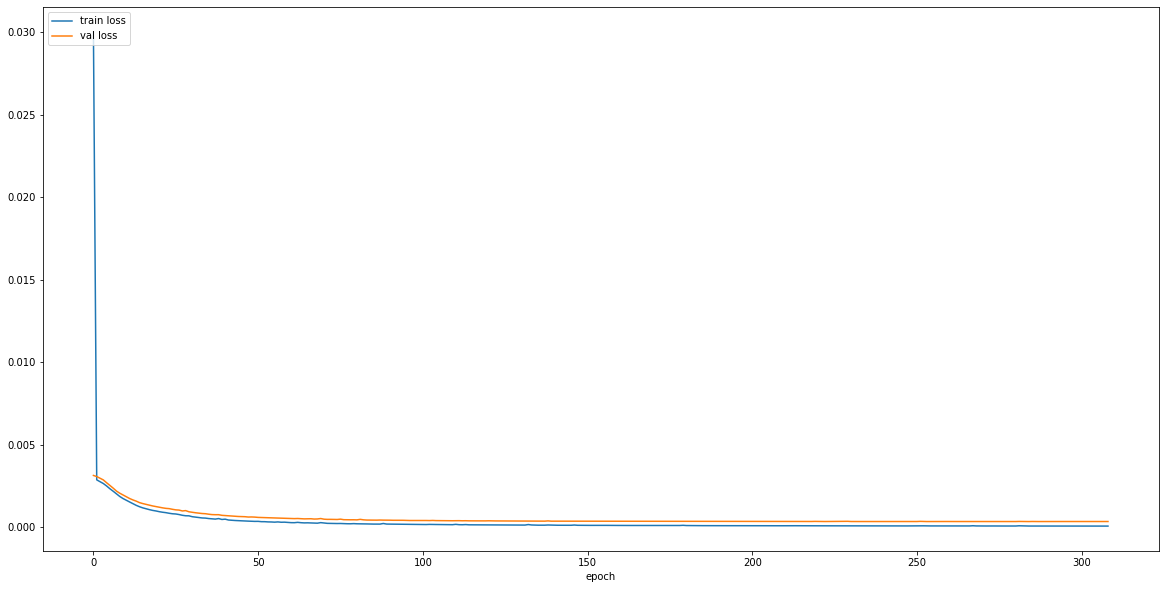

In [9]:
training_curve(hist, False)

In [10]:
inputlayer = layers.Input(shape=256)
hiddenlayer = layers.Dense(200)(inputlayer)
hiddenlayer = layers.BatchNormalization()(hiddenlayer)
hiddenlayer = layers.ReLU()(hiddenlayer)
hiddenlayer = layers.Dropout(0.45)(hiddenlayer)
hiddenlayer = layers.Dense(150)(hiddenlayer)
hiddenlayer = layers.BatchNormalization()(hiddenlayer)
hiddenlayer = layers.ReLU()(hiddenlayer)
hiddenlayer = layers.Dropout(0.15)(hiddenlayer)
outputlayer = layers.Dense(target.shape[1])(hiddenlayer)

In [17]:
model = models.Model(inputlayer, outputlayer)
model.compile(optimizer=Adam(learning_rate=0.00015), loss=losses.BinaryCrossentropy(), metrics=[acc, metrics.BinaryAccuracy()])
model.summary()

Tensor("metrics_6/acc/Cast_1:0", shape=(), dtype=float32)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               51400     
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
re_lu (ReLU)                 (None, 200)               0         
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 150)               30150     
_________________________________________________________________
b

In [18]:
hist = model.fit(encoder(df[irms.columns].values).numpy(), df[target.columns], epochs=1000, batch_size=64, validation_split=0.2)

Train on 6121 samples, validate on 1531 samples
Epoch 1/1000
Tensor("metrics/acc/Cast_2:0", dtype=float32)
Tensor("metrics/acc/Cast_2:0", dtype=float32)
6121/6121 [==============================] - 1s 191us/sample - loss: 1.0219 - acc: 0.0000e+00 - binary_accuracy: 0.8732 - val_loss: 0.7669 - val_acc: 0.0000e+00 - val_binary_accuracy: 0.8931
Epoch 2/1000
6121/6121 [==============================] - 1s 86us/sample - loss: 1.0004 - acc: 0.0000e+00 - binary_accuracy: 0.8762 - val_loss: 0.7743 - val_acc: 0.0000e+00 - val_binary_accuracy: 0.8926
Epoch 3/1000
6121/6121 [==============================] - 1s 90us/sample - loss: 1.0095 - acc: 0.0000e+00 - binary_accuracy: 0.8750 - val_loss: 0.7864 - val_acc: 0.0000e+00 - val_binary_accuracy: 0.8917
Epoch 4/1000
6121/6121 [==============================] - 0s 78us/sample - loss: 0.9867 - acc: 0.0000e+00 - binary_accuracy: 0.8739 - val_loss: 0.7545 - val_acc: 0.0000e+00 - val_binary_accuracy: 0.8925
Epoch 5/1000
6121/6121 [=======================

KeyboardInterrupt: 

In [ ]:
training_curve(hist, True)

In [14]:
activation = 'elu'
inputlayer = layers.Input(shape=(irms.shape[1], 1))
hiddenlayer = layers.Conv1D(16, 3, activation=activation)(inputlayer)
hiddenlayer = layers.MaxPooling1D(2)(hiddenlayer)
hiddenlayer = layers.Conv1D(16, 3, activation=activation)(hiddenlayer)
hiddenlayer = layers.MaxPooling1D(2)(hiddenlayer)
hiddenlayer = layers.Conv1D(16, 3, activation=activation)(hiddenlayer)
hiddenlayer = layers.MaxPooling1D(2)(hiddenlayer)
hiddenlayer = layers.Conv1D(16, 3, activation=activation)(hiddenlayer)
hiddenlayer = layers.MaxPooling1D(2)(hiddenlayer)
hiddenlayer = layers.Conv1D(16, 3, activation=activation)(hiddenlayer)
hiddenlayer = layers.MaxPooling1D(2)(hiddenlayer)
hiddenlayer = layers.Conv1D(16, 3, activation=activation)(hiddenlayer)
hiddenlayer = layers.MaxPooling1D(2)(hiddenlayer)
hiddenlayer = layers.Conv1D(16, 3, activation=activation)(hiddenlayer)
hiddenlayer = layers.Flatten()(hiddenlayer)
hiddenlayer = layers.Dense(256, activation=activation)(hiddenlayer)
hiddenlayer = layers.Dropout(0.45)(hiddenlayer)
hiddenlayer = layers.Dense(128, activation=activation)(hiddenlayer)
hiddenlayer = layers.Dropout(0.15)(hiddenlayer)
outputlayer = layers.Dense(target.shape[1], activation='sigmoid')(hiddenlayer)

In [15]:
model = models.Model(inputlayer, outputlayer)
model.compile(optimizer=Adam(learning_rate=1e-3), loss=losses.BinaryCrossentropy(), metrics=[acc, metrics.BinaryAccuracy()])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1757, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1755, 16)          64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 877, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 875, 16)           784       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 437, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 435, 16)           784       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 217, 16)           0   

In [20]:
hist = model.fit(np.expand_dims(df[irms.columns].values, axis=-1), df[target.columns].values, epochs=1000, batch_size=64, validation_split=0.2)

ValueError: Error when checking input: expected input_3 to have 3 dimensions, but got array with shape (7652, 1757)

<Figure size 1440x720 with 0 Axes>

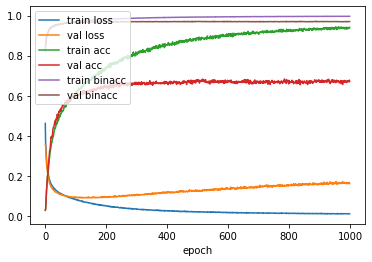

In [24]:
training_curve(hist, True)